In [145]:
from utils.extract import F1DataProcessor
from utils.telemetry import F1TelemetryAnalyzer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
f1_processor = F1DataProcessor("cache", 2024)
quali_df = f1_processor.get_quali_session([5])

core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '4', '81', '16', '55', '63', '27', '77', '18', '3', '31', '23', '10', '24', '20', '44', '22', '2']
/Users/katecastillo/Documents/learning/f1-exploration/utils/extract.py:59: SettingWithCopyWarning: 
A value i

/Users/katecastillo/Documents/learning/f1-exploration/utils/telemetry.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


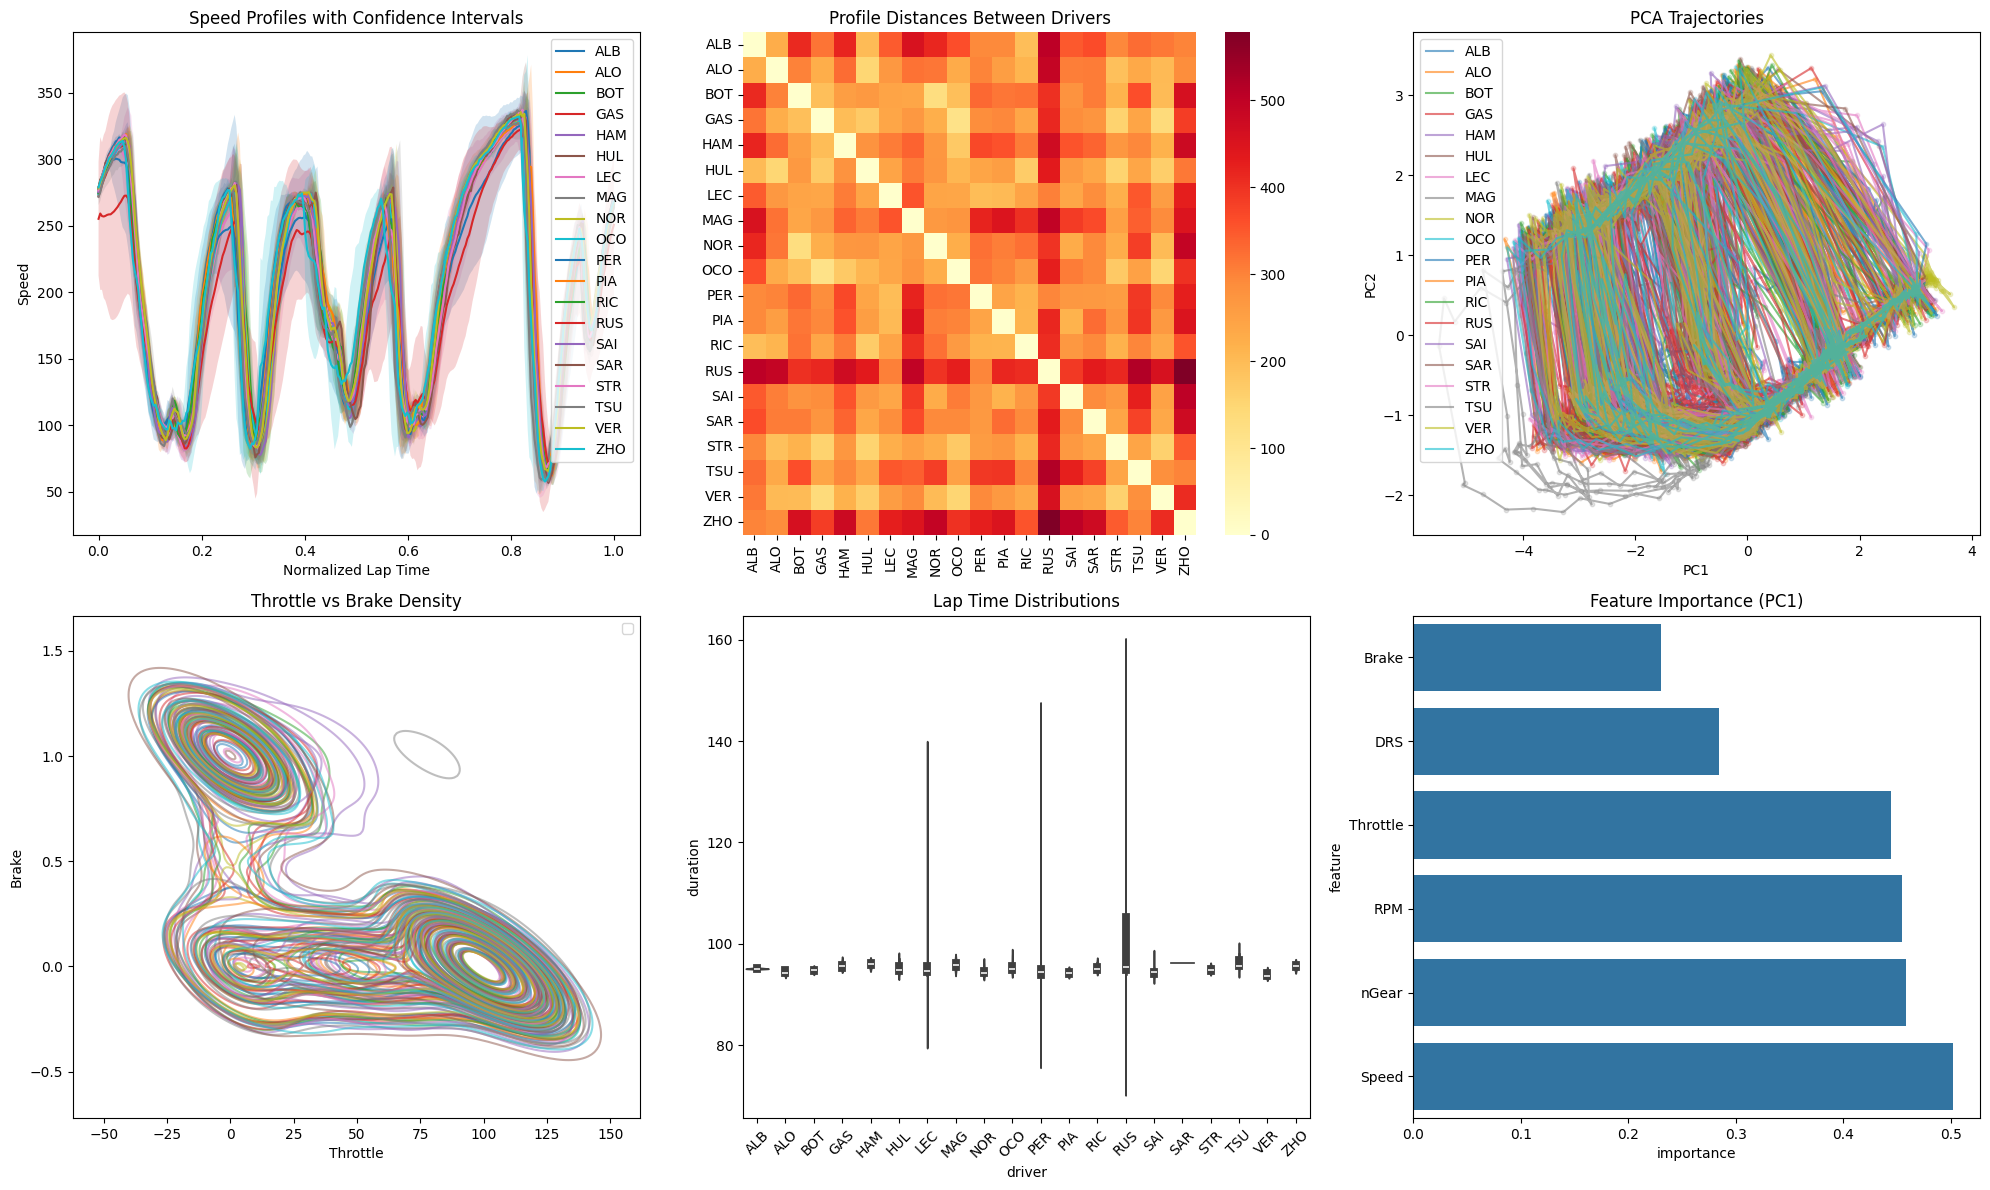

In [147]:
analyzer = F1TelemetryAnalyzer(n_samples=300)  # Set fixed number of samples per lap
results = analyzer.analyze_laps(quali_df)